In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import pandas as pd
import community as community_louvain
from scipy.optimize import curve_fit
from networkx.algorithms.community import greedy_modularity_communities
from scipy.integrate import simps
from numpy import trapz
import random

# Preprocessing and Statistics

In [ ]:
file_path = '19980201.all-paths'
with open(file_path, 'r') as file:
    lines = [next(file) for _ in range(10)]
lines

['routeviews/routeviews|5 3561|3847|6618 198.137.143.0/24 i 204.70.4.89\n',
 'routeviews/routeviews|1 1673|3561|6503|3632 200.33.65.0/24 i 206.157.77.11\n',
 'routeviews/routeviews|5 1849|702|701|3479 141.165.0.0/16 i 158.43.133.48\n',
 'routeviews/routeviews|5 1740|1239 198.72.4.0/23 i 134.24.127.3\n',
 'routeviews/routeviews|2 2497|2914|1 138.196.0.0/16 i 202.232.1.8\n',
 'routeviews/routeviews|5 234|266|237|3561|5683|7474|7570 192.82.161.0/24 i 204.212.44.128\n',
 'routeviews/routeviews|5 293|3561|2516|4681 202.228.192.0/18 i 134.55.24.6\n',
 'routeviews/routeviews|5 3561|1239|4000|4623|4650 202.69.240.0/20 i 204.70.4.89\n',
 'routeviews/routeviews|5 3561|1740 198.151.8.0/21 ? 204.70.4.89\n',
 'routeviews/routeviews|5 3561|701|816 209.47.100.0/24 i 204.70.4.89\n']

In [ ]:
def pars_paths(parts):
  parts = parts.split('|')
  collector_info = parts[0] + '|' + parts[1].split(' ')[0]
  collectors = parts[0]
  freq = parts[1].split(' ')[0]
  as_start = parts[1].split(' ', 1)[1]
  if len(parts[2:]) != 1:
    m_paths = parts[2:][:-1]
  as_end = parts[2:][-1].split(' ')[0]
  ips = parts[2:][-1].split(' ')[1:]
  as_paths = [as_start] + m_paths + [as_end]
  return (collectors, freq, as_paths, ips)

In [ ]:
graph = nx.Graph()
with open(file_path, 'r') as file:
    for line in file.readlines():
      parts = line.strip().split('|')
      if len(parts) < 5:
          continue  # Ensure we have all the necessary parts
      paths = pars_paths(line)[2]
      for i in range(len(paths) - 1):
          graph.add_edge(paths[i], paths[i + 1])

In [ ]:
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()
num_components = nx.number_connected_components(graph)
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
avg_clustering_coefficient = nx.average_clustering(graph)

if nx.is_connected(graph):
    graph.remove_edges_from(nx.selfloop_edges(graph))
    path_lengths = dict(nx.all_pairs_shortest_path_length(graph))
    lengths = [length for target_dict in path_lengths.values() for length in target_dict.values()]
    min_path_length = min(lengths)
    max_path_length = max(lengths)
    avg_path_length = np.mean(lengths)

    print(f"Minimum path length: {min_path_length}")
    print(f"Maximum path length: {max_path_length}")
    print(f"Average path length: {avg_path_length:.2f}")
else:
    print("The graph is not connected. Consider analyzing each connected component separately.")

print('num_nodes: ', num_nodes)
print('num_edges: ', num_edges)
print('num_components: ', num_components)
print('max degree: ', degree_sequence[0])
print('min degree: ', degree_sequence[-1])
print('avg_clustering_coefficient: ', avg_clustering_coefficient)

Minimum path length: 0
Maximum path length: 9
Average path length: 3.79
num_nodes:  3338
num_edges:  5643
num_components:  1
max degree:  682
min degree:  1
avg_clustering_coefficient:  0.16509250022104022


In [ ]:
path_lengths = []
for source in graph.nodes():
    for target in graph.nodes():
        if source != target:
            try:
                length = nx.shortest_path_length(graph, source=source, target=target)
                path_lengths.append(length)
            except nx.NetworkXNoPath:
                continue

In [ ]:
print('min path length', min(path_lengths))
print('max path length', max(path_lengths))
print('avg path length', np.mean(path_lengths))

In [ ]:
nx.write_gml(graph, "as_graph.gml")

# ASes Network Construction

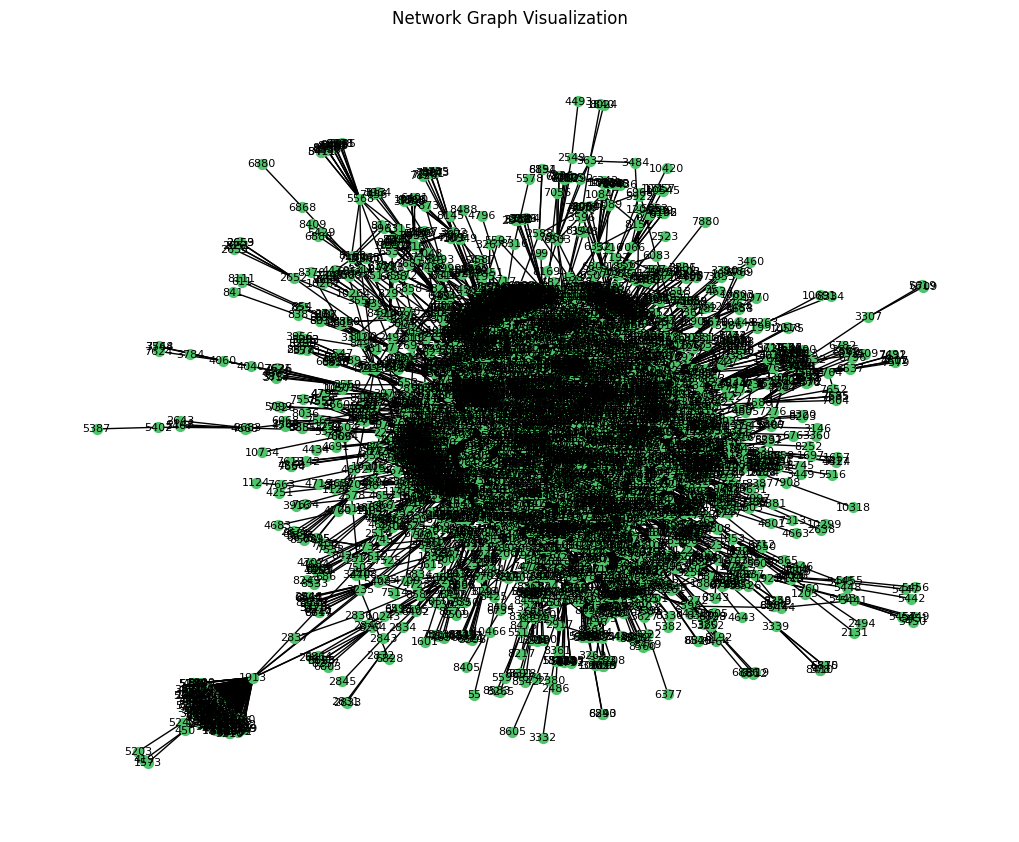

In [ ]:
plt.figure(figsize=(10, 8))
nx.draw(graph, with_labels=True, node_size=50, font_size=8, node_color='#50C46C')
plt.title("Network Graph Visualization")
plt.show()

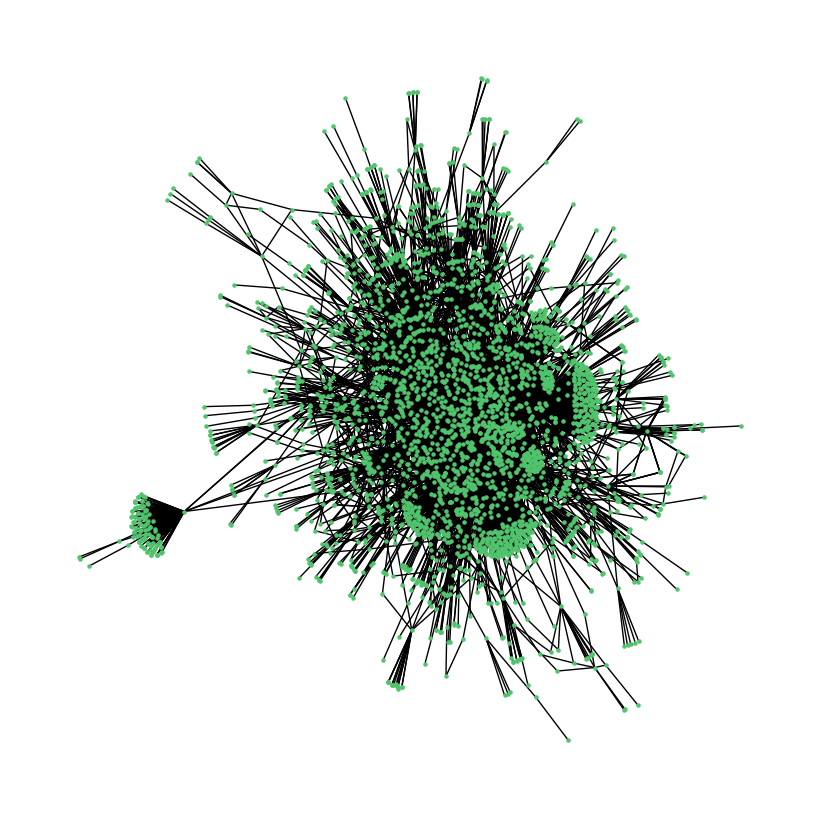

In [ ]:
# using the force-based or "spring" layout algorithm
fig = plt.figure(figsize=(8,8))
nx.draw_spring(graph, node_size=5, node_color='#50C46C')

## Degree Distribution

In [ ]:
N = len(graph)
L = graph.size()
degrees = [graph.degree(node) for node in graph]
kmin = min(degrees)
kmax = max(degrees)

print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  3338
Number of edges:  5643

Average degree:  3.3810665068903534

Minimum degree:  1
Maximum degree:  682


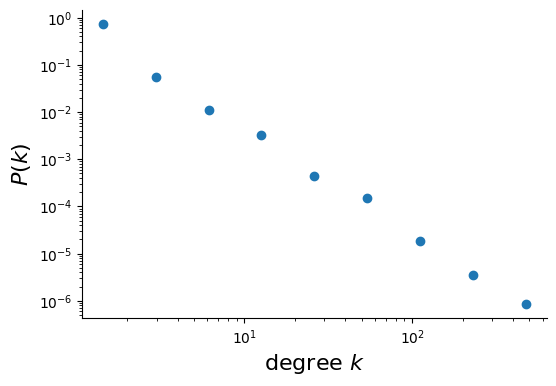

In [ ]:
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

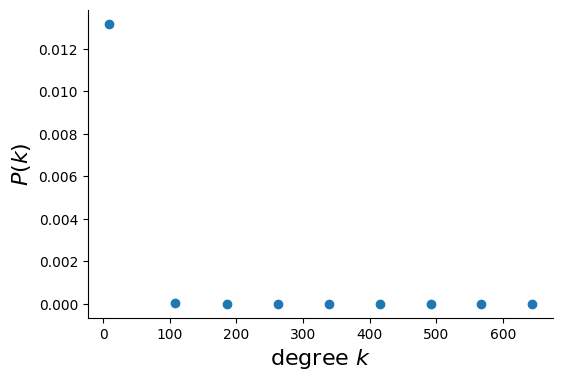

In [ ]:
# Get 20 logarithmically spaced bins between kmin and kmax
bin_edges = np.linspace(kmin, kmax, num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [ ]:
def plot_degree_dist(G):

    degrees = [G.degree(n) for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)

    if kmin>0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=20)
    else:
        bin_edges = np.logspace(0, np.log10(kmax)+1, num=20)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    fig = plt.figure(figsize=(6,4))

    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none', color='#50C46C')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

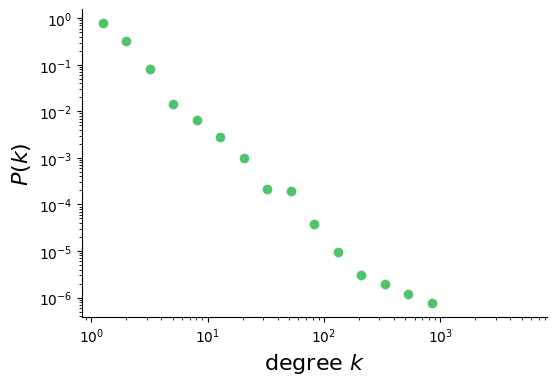

In [ ]:
plot_degree_dist(graph)

## Null model

In [ ]:
# ...and calculate the clustering coefficient and average path length

C = np.mean(list(nx.clustering(graph).values()))
d = nx.average_shortest_path_length(graph,weight=None)

print("Average Clustering Coefficient: ", C)
print("Average Shortest Path: ", d)

Average Clustering Coefficient:  0.16509250022104024
Average Shortest Path:  3.7864231909309587


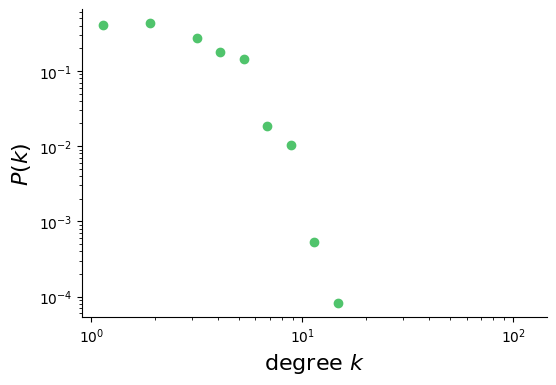

In [ ]:
GN = len(graph.nodes()) # G.number_of_nodes()
max_L = GN*(GN-1)/2
actual_L = len(graph.edges())
p = actual_L/max_L

ER = nx.erdos_renyi_graph(GN, p, directed=False)

plot_degree_dist(ER)

# NSI

In [ ]:
zip_file_path = "fb-pages-artist.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()
print("Extracted files:", os.listdir())

Extracted files: ['.config', 'fb-pages-artist.nodes', 'readme.html', 'fb-pages-artist.zip', 'fb-pages-artist.edges', 'sample_data']


In [ ]:
G = nx.Graph()

node_file_path = "fb-pages-artist.nodes"
with open(node_file_path, 'r') as node_file:
    for line in node_file:
        node = line.strip()
        G.add_node(node)

edge_file_path = "fb-pages-artist.edges"
with open(edge_file_path, 'r') as edge_file:
    for line in edge_file:
        node1, node2 = line.strip().split(',')
        G.add_edge(node1, node2)

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

assortativity = nx.degree_assortativity_coefficient(G)

global_clustering = nx.average_clustering(G)

def sample_average_closeness(G, sample_size=100):
    nodes = list(G.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    closeness_values = [nx.closeness_centrality(G, node) for node in sampled_nodes]
    return np.mean(closeness_values)

sample_size = 100
average_closeness_approx = sample_average_closeness(G, sample_size)
print(f"Approximate Average Closeness Centrality: {average_closeness_approx}")

In [ ]:
num_nodes, num_edges, assortativity, global_clustering

(101008, 819306, -0.019066260682511466, 0.06907525219949652)

In [60]:
network_density = nx.density(G)

def fit_power_law(degrees):
    degrees = degrees[degrees > 0]
    log_degrees = np.log(degrees)
    hist, edges = np.histogram(log_degrees, bins=50, density=True)
    bin_centers = (edges[:-1] + edges[1:]) / 2

    def power_law(x, alpha):
        return x**(-alpha)

    params, _ = curve_fit(power_law, np.exp(bin_centers), hist, p0=np.array([2.0]))
    return params[0]

degree_sequence = np.array([degree for node, degree in G.degree()])
alpha = fit_power_law(degree_sequence)
communities = greedy_modularity_communities(G)
modularity = nx.algorithms.community.modularity(G, communities)

In [ ]:
print('num_nodes', num_nodes)
print('num_edges', num_edges)
print('assortativity', assortativity)
print('global_clustering', global_clustering)
print('average_closeness', average_closeness_approx)
print('network_density', network_density)
print('alpha', alpha)
print('modularity', modularity)

# Robustness

In [53]:
G = nx.DiGraph()

with open('CA-GrQc.txt', 'r') as file:
    for line in file:
        if line.startswith('#'):
            continue
        source, target = line.strip().split()
        G.add_edge(source, target)

In [85]:
def robustness_analysis(G, attack):
    if attack not in ['betweenness', 'recalculated_betweenness', 'degree', 'recalculated_degree', 'random']:
        raise ValueError("Invalid attack strategy.")

    LCC_sizes = []
    qs = []
    total_nodes = G.number_of_nodes()

    if attack == 'betweenness':
        centrality = nx.betweenness_centrality(G)
        ranked_nodes = sorted(centrality, key=centrality.get, reverse=True)
    elif attack == 'degree':
        centrality = nx.degree_centrality(G)
        ranked_nodes = sorted(centrality, key=centrality.get, reverse=True)

    i = 0
    while G.number_of_nodes() > 0:
        largest_cc = max(nx.connected_components(G), key=len)
        LCC_size = len(largest_cc) / total_nodes
        LCC_sizes.append(LCC_size)

        q = 1 - (G.number_of_nodes() / total_nodes)
        qs.append(q)

        if attack in ['recalculated_betweenness', 'recalculated_degree']:
            if attack == 'recalculated_betweenness':
                centrality = nx.betweenness_centrality(G)
            else:
                centrality = nx.degree_centrality(G)

            max_node = max(centrality, key=centrality.get)
            G.remove_node(max_node)
        elif attack == 'random':
          node_to_remove = random.choice(list(G.nodes()))
          G.remove_node(node_to_remove)

        else:
            if i < len(ranked_nodes):
                G.remove_node(ranked_nodes[i])
                i += 1

    area = trapz(LCC_sizes, qs)
    R = area / 1

    return R, LCC_sizes, qs

Analyzing betweenness...
betweenness attack: R = 0.05714685454450968
Analyzing degree...
degree attack: R = 0.08195946847877494
Analyzing random...
random attack: R = 0.29354399669502373


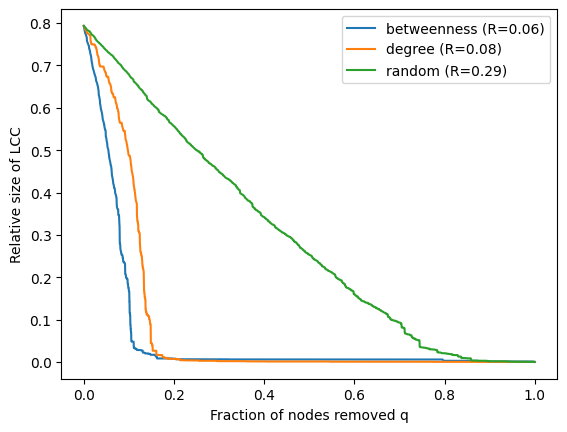

In [ ]:
G = G.to_undirected()

results = {}
for attack in ['betweenness', 'degree', 'random']:
    print(f"Analyzing {attack}...")
    R, LCC_sizes, qs = robustness_analysis(G.copy(), attack)
    results[attack] = {'R': R, 'LCC_sizes': LCC_sizes, 'qs': qs}
    print(f"{attack} attack: R = {R}")

fig, ax = plt.subplots()
for attack, result in results.items():
    ax.plot(result['qs'], result['LCC_sizes'], label=f"{attack} (R={result['R']:.2f})")

ax.set_xlabel('Fraction of nodes removed q')
ax.set_ylabel('Relative size of LCC')
ax.legend()
plt.show()

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz
import random

def robustness_analysis(G, attack, precalculated_centrality=None):
    LCC_sizes = []
    qs = []
    total_nodes = G.number_of_nodes()

    if precalculated_centrality is not None and attack != 'random':
        centrality = precalculated_centrality
        ranked_nodes = sorted(centrality, key=centrality.get, reverse=True)
    elif attack in ['recalculated_betweenness', 'recalculated_degree', 'recalculated_closeness', 'random']:
        ranked_nodes = None
    else:
        print(precalculated_centrality, attack)
        raise ValueError("Invalid or unsupported attack strategy.")

    i = 0
    while G.number_of_nodes() > 0:
        largest_cc = max(nx.connected_components(G), key=len)
        LCC_size = len(largest_cc) / total_nodes
        LCC_sizes.append(LCC_size)

        q = 1 - (G.number_of_nodes() / total_nodes)
        qs.append(q)

        if attack.startswith('recalculated_'):
            if attack == 'recalculated_betweenness':
                centrality = nx.betweenness_centrality(G)
            elif attack == 'recalculated_degree':
                centrality = nx.degree_centrality(G)
            elif attack == 'recalculated_closeness':
                centrality = nx.closeness_centrality(G)
            max_node = max(centrality, key=centrality.get)
            G.remove_node(max_node)
        elif attack == 'random':
            node_to_remove = random.choice(list(G.nodes()))
            G.remove_node(node_to_remove)
        else:
            G.remove_node(ranked_nodes[i])
            i += 1

    area = trapz(LCC_sizes, qs)
    R = area / 1
    return R, LCC_sizes, qs

def robustness_analysis_with_monte_carlo(G_original, attack, model, num_experiments=100):
    robustness_results = []

    precalculated_centrality = {
    'betweenness': nx.betweenness_centrality(G_original),
    'degree': nx.degree_centrality(G_original),
    'closeness': nx.closeness_centrality(G_original)
    }

    GN = len(G_original.nodes())
    actual_L = len(G_original.edges())
    max_L = GN * (GN - 1) / 2
    p = actual_L / max_L  # Probability for edge creation in ER model

    for experiment in range(num_experiments):
        if model == "ER":
            G = nx.erdos_renyi_graph(GN, p, directed=False)
        elif model == "DP":
            DP = G_original.copy()  # Start with a copy of the original graph for each experiment
            nx.double_edge_swap(DP, nswap=10 * actual_L, max_tries=100000)
            G = DP
        else:
            G = G_original.copy()
        if precalculated_centrality and attack in precalculated_centrality and model == "original":
            R, _, _ = robustness_analysis(G, attack, precalculated_centrality=precalculated_centrality[attack])
        else:
            precalculated_centrality = {
            'betweenness': nx.betweenness_centrality(G),
            'degree': nx.degree_centrality(G),
            'closeness': nx.closeness_centrality(G),
            'random': None,
            'recalculated_degree': None
              }
            R, _, _ = robustness_analysis(G, attack, precalculated_centrality=precalculated_centrality[attack])
        robustness_results.append(R)

    average_robustness = sum(robustness_results) / num_experiments
    return average_robustness

# Example graph
# G = nx.scale_free_graph(100).to_undirected()

# Pre-calculate centralities for applicable strategies
# initial_centrality = {
#     'betweenness': nx.betweenness_centrality(G),
#     'degree': nx.degree_centrality(G),
#     'closeness': nx.closeness_centrality(G)
# }


In [ ]:
initial_centrality = {
    'betweenness': nx.betweenness_centrality(G),
    'degree': nx.degree_centrality(G),
    'closeness': nx.closeness_centrality(G)
}

Analyzing betweenness with Monte Carlo simulations...
betweenness attack: Average R = 0.0186
Analyzing random with Monte Carlo simulations...
random attack: Average R = 0.3673
Analyzing closeness with Monte Carlo simulations...
closeness attack: Average R = 0.1150
Analyzing recalculated_degree with Monte Carlo simulations...
recalculated_degree attack: Average R = 0.0157


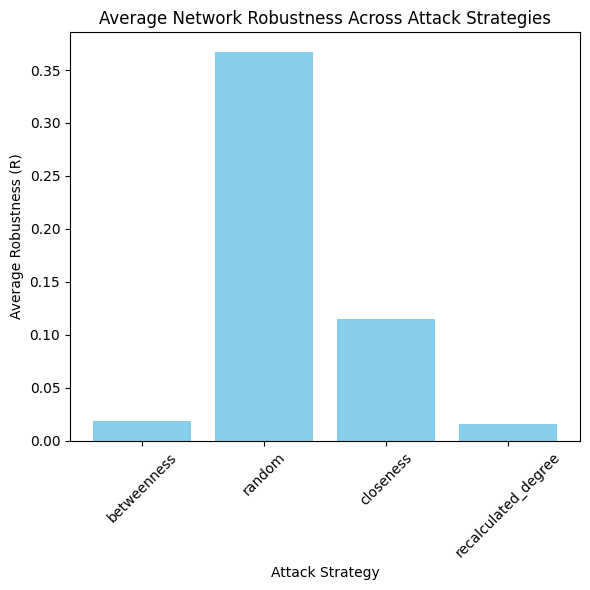

Analyzing betweenness with Monte Carlo simulations...


ValueError: Invalid or unsupported attack strategy.

In [ ]:
num_experiments = 5
attack_strategies = ['betweenness', 'random', 'closeness', 'recalculated_degree']
models = ['original']


# Calculate average robustness for each attack strategy
average_results = {}
for model in models:
  for attack in attack_strategies:
      print(f"Analyzing {attack} with Monte Carlo simulations...")
      average_R = robustness_analysis_with_monte_carlo(G, attack, model, num_experiments)
      average_results[attack] = average_R
      print(f"{attack} attack: Average R = {average_R:.4f}")

  labels = attack_strategies
  average_robustness_scores = [average_results[attack] for attack in labels]

  plt.figure(figsize=(6, 6))
  plt.bar(labels, average_robustness_scores, color='skyblue')
  plt.xlabel('Attack Strategy')
  plt.ylabel('Average Robustness (R)')
  plt.title('Average Network Robustness Across Attack Strategies')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()


Analyzing random with Monte Carlo simulations...
random attack: Average R = 0.3766
Analyzing betweenness with Monte Carlo simulations...
betweenness attack: Average R = 0.2272
Analyzing closeness with Monte Carlo simulations...
closeness attack: Average R = 0.2909
Analyzing recalculated_degree with Monte Carlo simulations...
recalculated_degree attack: Average R = 0.1608


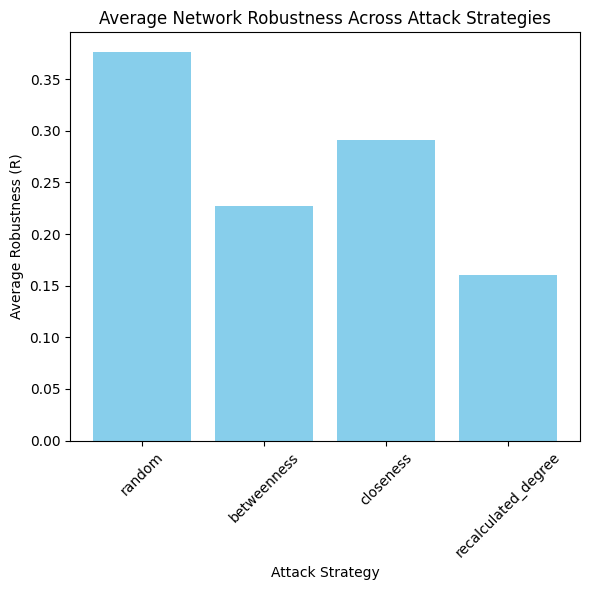

Analyzing random with Monte Carlo simulations...


NetworkXError: Number of swaps > number of tries allowed.

In [ ]:
num_experiments = 5
attack_strategies = ['random', 'betweenness', 'closeness', 'recalculated_degree']
models = ['ER', 'DP']


average_results = {}
for model in models:
  for attack in attack_strategies:
      print(f"Analyzing {attack} with Monte Carlo simulations...")
      average_R = robustness_analysis_with_monte_carlo(G, attack, model, num_experiments)
      average_results[attack] = average_R
      print(f"{attack} attack: Average R = {average_R:.4f}")

  labels = attack_strategies
  average_robustness_scores = [average_results[attack] for attack in labels]

  plt.figure(figsize=(6, 6))
  plt.bar(labels, average_robustness_scores, color='skyblue')
  plt.xlabel('Attack Strategy')
  plt.ylabel('Average Robustness (R)')
  plt.title('Average Network Robustness Across Attack Strategies')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()


Analyzing random with Monte Carlo simulations...
random attack: Average R = 0.3210
Analyzing betweenness with Monte Carlo simulations...
betweenness attack: Average R = 0.0183
Analyzing closeness with Monte Carlo simulations...
closeness attack: Average R = 0.0344
Analyzing recalculated_degree with Monte Carlo simulations...
recalculated_degree attack: Average R = 0.0143


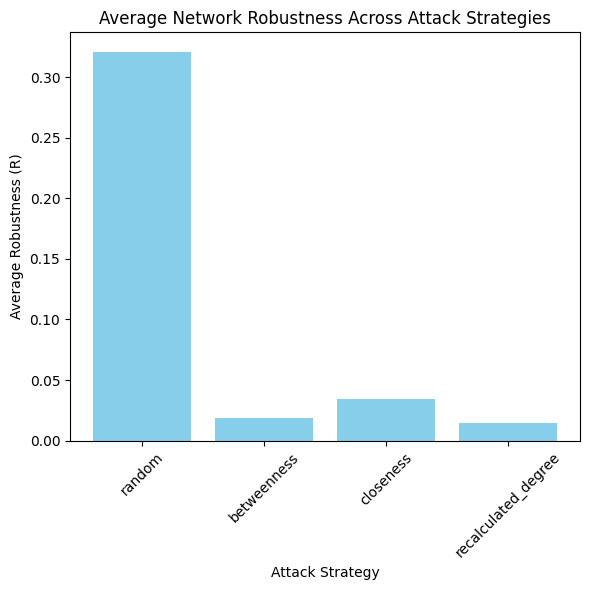

In [ ]:
# Number of Monte Carlo simulations
num_experiments = 5

# Attack strategies
attack_strategies = ['random', 'betweenness', 'closeness', 'recalculated_degree']

models = ['DP']


# Calculate average robustness for each attack strategy
average_results = {}
for model in models:
  for attack in attack_strategies:
      print(f"Analyzing {attack} with Monte Carlo simulations...")
      average_R = robustness_analysis_with_monte_carlo(G, attack, model, num_experiments)
      average_results[attack] = average_R
      print(f"{attack} attack: Average R = {average_R:.4f}")

  # Plotting the average robustness for each attack strategy
  labels = attack_strategies
  average_robustness_scores = [average_results[attack] for attack in labels]

  plt.figure(figsize=(6, 6))
  plt.bar(labels, average_robustness_scores, color='skyblue')
  plt.xlabel('Attack Strategy')
  plt.ylabel('Average Robustness (R)')
  plt.title('Average Network Robustness Across Attack Strategies')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()


# Calcualting NSI for each networks

## Loading the networks

In [8]:
zip_file_path = "datasets.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
def extract_files(file_name):
  G = nx.DiGraph()
  with open(file_name, 'r') as file:
    if file_name.split('.')[1] == 'txt':
      for line in file:
        if line.startswith('#'):
              continue
        nodes = line.strip().split()
        G.add_edge(nodes[0], nodes[1])

    elif file_name.split('.')[1] == 'mtx':
      for line in file:
        line = line.strip().split(' ')
        if len(line) == 2:
          G.add_edge(line[0], line[1])

    elif file_name.split('.')[1] == 'edges':
      for line in file:
        if line.startswith('%'):
              continue
        line = line.strip().split(',')
        G.add_edge(line[0], line[1])


    elif file_name.split('.')[1] == 'csv':
      df = pd.read_csv(file_name)
      source = list(df)[0]
      target = list(df)[1]
      G = nx.from_pandas_edgelist(df, source, target)

  return G

In [63]:
def extract_from_node_edge(file_name):
  node_file_path = file_name + '.nodes'
  with open(node_file_path, 'r') as node_file:
      for line in node_file:
          node = line.strip()
          G.add_node(node)

  edge_file_path = file_name + '.edges'
  with open(edge_file_path, 'r') as edge_file:
      for line in edge_file:
          node1, node2 = line.strip().split(',')
          G.add_edge(node1, node2)
  return G

In [16]:
graphs = []
folders = os.listdir()
for folder in folders:
  if folder == 'mtx':
    for files in os.listdir(folder):
      graphs.append((files, extract_files(folder+'/'+files)))
  # else:
  #   for files in os.listdir(folder):
  #     graphs.append((files, extract_from_node_edge(folder+'/'+files)))
len(graphs)

3

In [1]:
for name, G in graphs:
  print(name)
  G = G.to_undirected()
  results = {}
  for attack in ['betweenness', 'degree', 'random']:
      print(f"Analyzing {attack}...")
      R, LCC_sizes, qs = robustness_analysis(G.copy(), attack)
      results[attack] = {'R': R, 'LCC_sizes': LCC_sizes, 'qs': qs}
      print(f"{attack} attack: R = {R}")
  print('*'*20)

In [25]:
for G in graphs:
  print(f"Number of nodes: {G.number_of_nodes()}")
  print(f"Number of edges: {G.number_of_edges()}")
  print('*'*20)

Number of nodes: 36692
Number of edges: 367662
********************
Number of nodes: 82168
Number of edges: 948464
********************
Number of nodes: 23133
Number of edges: 186936
********************
Number of nodes: 9877
Number of edges: 51971
********************
Number of nodes: 75879
Number of edges: 508837
********************
Number of nodes: 34546
Number of edges: 421578
********************
Number of nodes: 7115
Number of edges: 103689
********************
Number of nodes: 265214
Number of edges: 420045
********************
Number of nodes: 18772
Number of edges: 396160
********************
Number of nodes: 5242
Number of edges: 28980
********************
Number of nodes: 27770
Number of edges: 352807
********************
Number of nodes: 77360
Number of edges: 905468
********************
Number of nodes: 12008
Number of edges: 237010
********************


## Calculating NSI

In [7]:
G = extract_files('soc-gemsec-HU.edges')

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 47538
Number of edges: 222887


In [8]:
assortativity = nx.degree_assortativity_coefficient(G)
print('assortativity', assortativity)

assortativity 0.04590745811215864


In [9]:
global_clustering = nx.average_clustering(G)
print('global_clustering', global_clustering)

global_clustering 0.05809361330624912


In [10]:
def sample_average_closeness(G, sample_size=10):
    nodes = list(G.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    closeness_values = [nx.closeness_centrality(G, node) for node in sampled_nodes]
    return np.mean(closeness_values)

sample_size = 100
average_closeness_approx = sample_average_closeness(G, sample_size)
print(f"Approximate Average Closeness Centrality: {average_closeness_approx}")
print('average_closeness', average_closeness_approx)

Approximate Average Closeness Centrality: 0.004695004647093117
average_closeness 0.004695004647093117


In [11]:
# degree
sum(dict(G.degree()).values()) / G.number_of_nodes()

9.377214018259076

In [79]:
network_density = nx.density(G)
print('network_density', network_density)

network_density 0.13920454545454544


In [12]:
def fit_power_law(degrees):
    degrees = degrees[degrees > 0]
    log_degrees = np.log(degrees)
    hist, edges = np.histogram(log_degrees, bins=50, density=True)
    bin_centers = (edges[:-1] + edges[1:]) / 2

    def power_law(x, alpha):
        return x**(-alpha)

    params, _ = curve_fit(power_law, np.exp(bin_centers), hist, p0=np.array([2.0]))
    return params[0]

degree_sequence = np.array([degree for node, degree in G.degree()])
alpha = fit_power_law(degree_sequence)
print('alpha', alpha)

alpha 14.722737869051693


In [84]:
communities = greedy_modularity_communities(G)
modularity = nx.algorithms.community.modularity(G, communities)
print('modularity', modularity)

modularity 0.3099171641445694


In [86]:
G = G.to_undirected()

results = {}
for attack in ['betweenness', 'degree', 'random']:
    print(f"Analyzing {attack}...")
    R, LCC_sizes, qs = robustness_analysis(G.copy(), attack)
    results[attack] = {'R': R, 'LCC_sizes': LCC_sizes, 'qs': qs}
    print(f"{attack} attack: R = {R}")

Analyzing betweenness...
betweenness attack: R = 0.2791551882460973
Analyzing degree...
degree attack: R = 0.3085399449035813
Analyzing random...
random attack: R = 0.4416896235078054


# Machine Learning

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
file_path = 'NSI.csv'
try:
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
except UnicodeDecodeError:
    try:
        df = pd.read_csv(file_path, encoding='cp1252')
    except Exception as e:
        print(f"An error occurred: {e}")

## Part 1

In [29]:
X = df.iloc[:, 2:11].values
y = df.iloc[:, 11].values

In [39]:
new_X = []
for i in X:
  new_values = []
  for j in i:
    if type(j) == str:
      j_list = j.split(',')
      j = float(j_list[0] + j_list[1])
    new_values.append(j)
  new_X.append(new_values)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.1)

### RF

In [25]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.06002800000000004
Mean Squared Error: 0.004145185159999999
Root Mean Squared Error: 0.06438311238205248
R-squared: 0.5751491103640538


### SVM

In [37]:
model_svm = SVR()
model_svm.fit(X_train, y_train)

predictions = model_svm.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.04539251515713865
Mean Squared Error: 0.002461411488032644
Root Mean Squared Error: 0.04961261420276746
R-squared: 0.16210120913921422


### Decision Tree

In [40]:
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)

predictions = model_dt.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.06859999999999998
Mean Squared Error: 0.006537399999999999
Root Mean Squared Error: 0.08085418974920223
R-squared: 0.11031573217201962


### Linear Regression

In [41]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

predictions = model_lr.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.07486029568150646
Mean Squared Error: 0.005933014714869167
Root Mean Squared Error: 0.07702606516543063
R-squared: 0.1925674040733305


### Ridge Regression

In [42]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)

predictions = model_rg.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.07481276397883516
Mean Squared Error: 0.007631476526563251
Root Mean Squared Error: 0.08735832259472048
R-squared: -0.038578732520856196


### Lasso Regression

In [43]:
model_l = Lasso()
model_l.fit(X_train, y_train)

predictions = model_l.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.06756643032266264
Mean Squared Error: 0.008106893239808791
Root Mean Squared Error: 0.0900382876325888
R-squared: -0.10327888402405994


### Elastic Net Regression

In [44]:
model_en = ElasticNet()
model_en.fit(X_train, y_train)

predictions = model_en.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.06755452183627145
Mean Squared Error: 0.008105144374712887
Root Mean Squared Error: 0.0900285753231322
R-squared: -0.10304087843125864


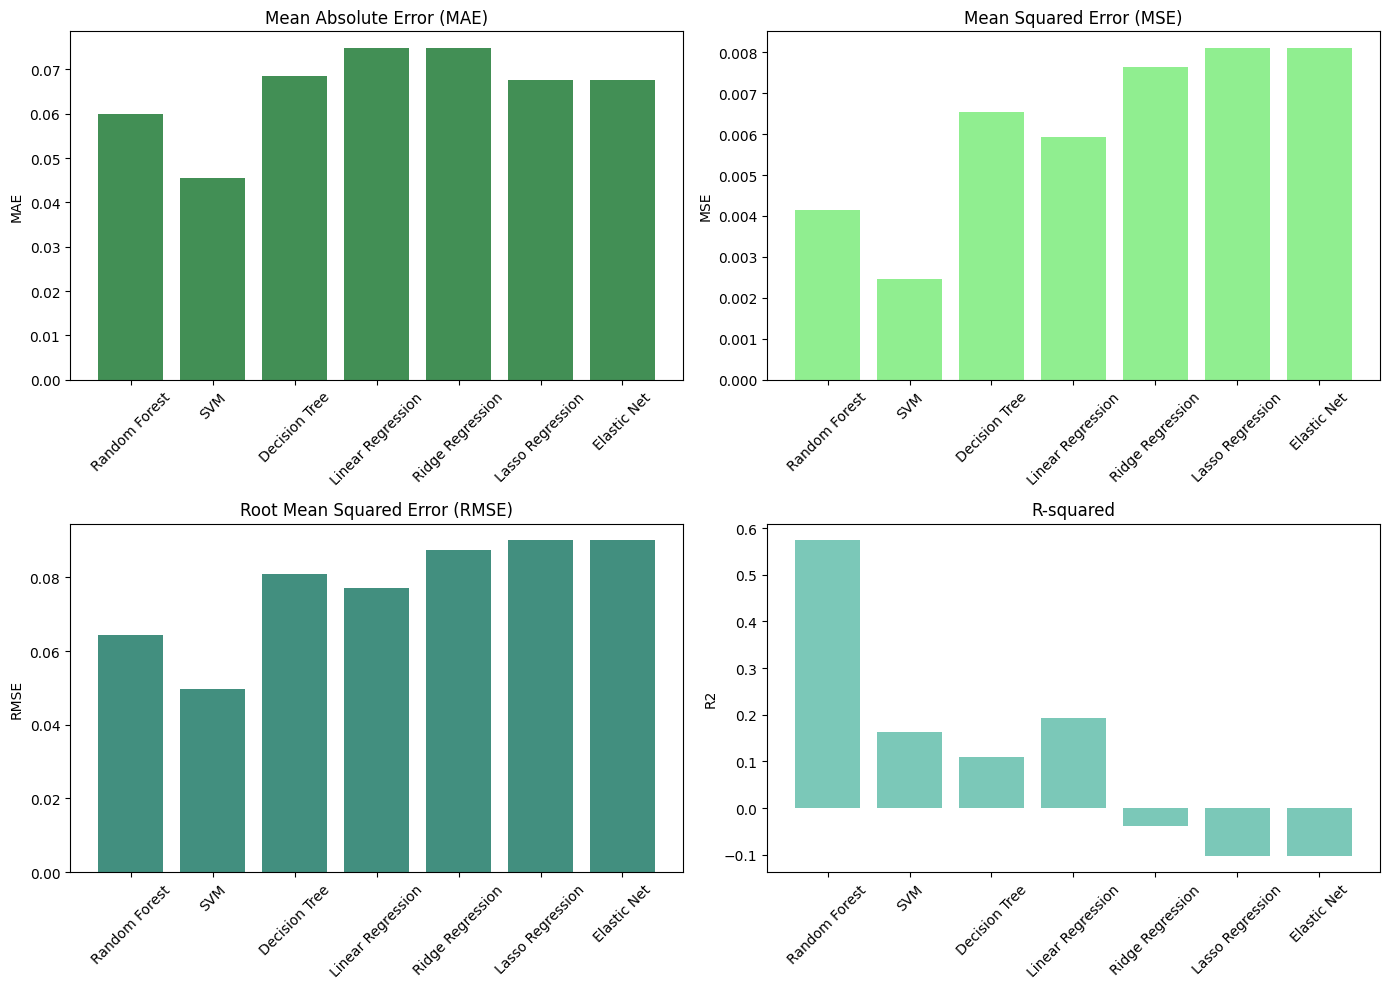

In [3]:
import matplotlib.pyplot as plt

models = ['Random Forest', 'SVM', 'Decision Tree', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net']
mae_values = [0.060028, 0.045393, 0.068600, 0.074860, 0.074813, 0.067566, 0.067555]
mse_values = [0.004145, 0.002461, 0.006537, 0.005933, 0.007631, 0.008107, 0.008105]
rmse_values = [0.064383, 0.049613, 0.080854, 0.077026, 0.087358, 0.090038, 0.090029]
r2_values = [0.575149, 0.162101, 0.110316, 0.192567, -0.038579, -0.103279, -0.103041]


fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].bar(models, mae_values, color='#428F55')
axs[0, 0].set_title('Mean Absolute Error (MAE)')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].tick_params(axis='x', rotation=45)

axs[0, 1].bar(models, mse_values, color='lightgreen')
axs[0, 1].set_title('Mean Squared Error (MSE)')
axs[0, 1].set_ylabel('MSE')
axs[0, 1].tick_params(axis='x', rotation=45)

axs[1, 0].bar(models, rmse_values, color='#428F7F')
axs[1, 0].set_title('Root Mean Squared Error (RMSE)')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].tick_params(axis='x', rotation=45)

axs[1, 1].bar(models, r2_values, color='#7BC8B8')
axs[1, 1].set_title('R-squared')
axs[1, 1].set_ylabel('R2')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Part 2

In [9]:
X = df.iloc[:, 2:11].values
y = df.iloc[:, 12].values

In [14]:
new_X = []
for i in X:
  new_values = []
  for j in i:
    if type(j) == str:
      j_list = j.split(',')
      j = float(j_list[0] + j_list[1])
    new_values.append(j)
  new_X.append(new_values)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.1)

In [11]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.07295599999999997
Mean Squared Error: 0.00913506563999999
Root Mean Squared Error: 0.09557753731918389
R-squared: 0.4205844450082463


### SVM

In [12]:
model_svm = SVR()
model_svm.fit(X_train, y_train)

predictions = model_svm.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.10377168504486059
Mean Squared Error: 0.012429707319693293
Root Mean Squared Error: 0.11148859726309814
R-squared: 0.21161313461288278


### Decision Tree

In [25]:
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)

predictions = model_dt.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.06280000000000001
Mean Squared Error: 0.007031599999999999
Root Mean Squared Error: 0.08385463612705024
R-squared: -0.5792830832809268


### Linear Regression

In [26]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

predictions = model_lr.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.03390408132979626
Mean Squared Error: 0.00223655712641968
Root Mean Squared Error: 0.04729225228744852
R-squared: 0.49767381043489356


### Ridge Regression

In [27]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)

predictions = model_rg.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.05107370746869956
Mean Squared Error: 0.003788756080488586
Root Mean Squared Error: 0.0615528722358964
R-squared: 0.14905307688244862


### Lasso Regression

In [28]:
model_l = Lasso()
model_l.fit(X_train, y_train)

predictions = model_l.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.0603593884066965
Mean Squared Error: 0.005063300742249554
Root Mean Squared Error: 0.07115687417424654
R-squared: -0.1372070663573699


### Elastic Net Regression

In [29]:
model_en = ElasticNet()
model_en.fit(X_train, y_train)

predictions = model_en.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error: 0.06036022542752421
Mean Squared Error: 0.005063515094083225
Root Mean Squared Error: 0.07115838035033699
R-squared: -0.13725520934399982


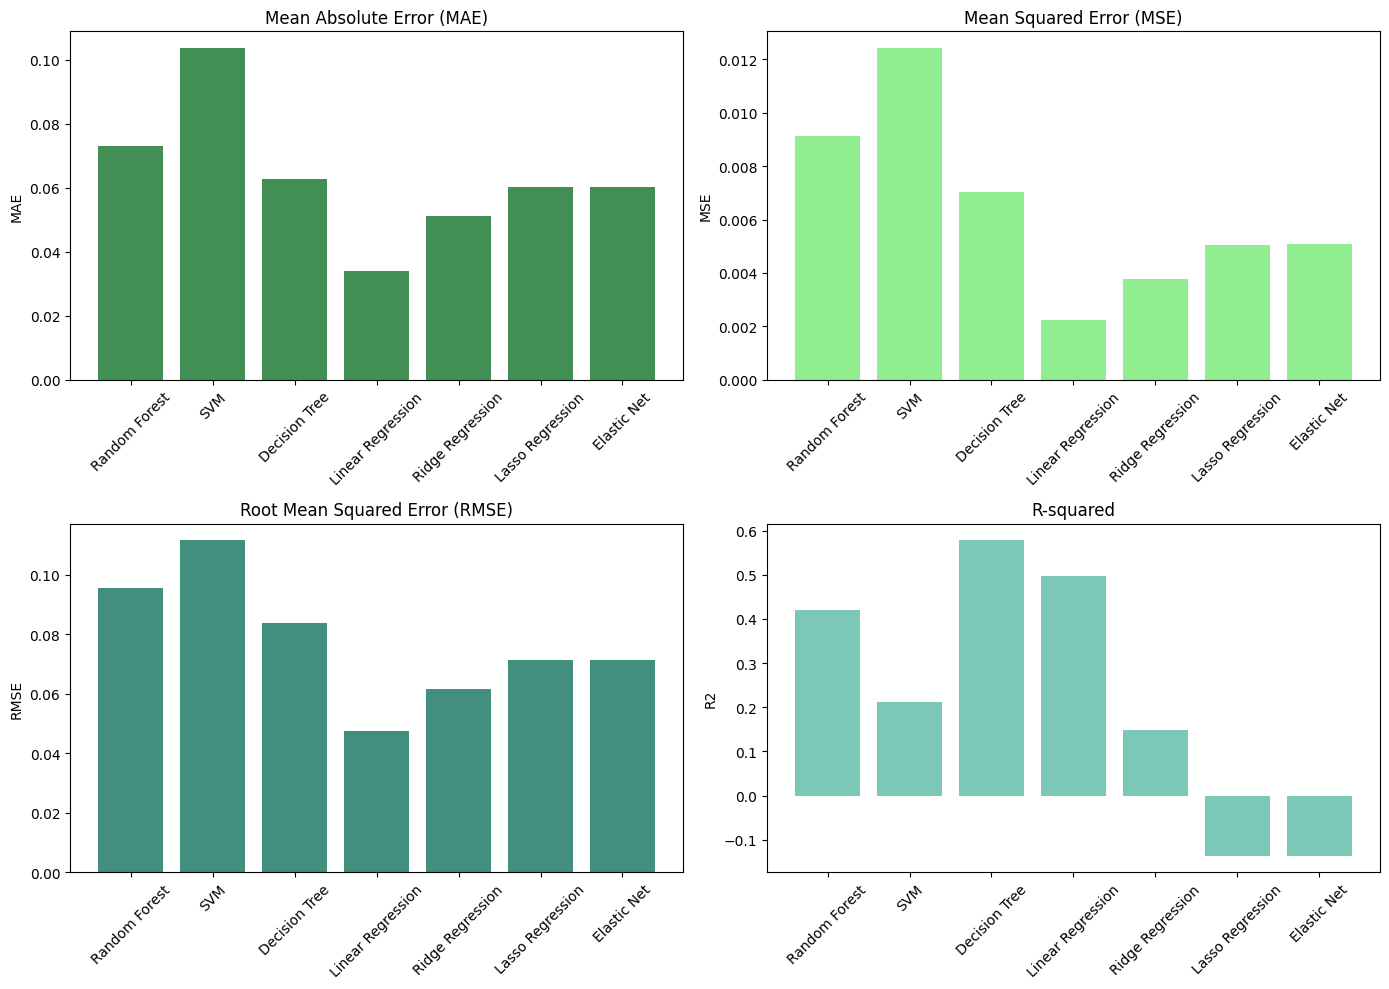

In [30]:
models = ['Random Forest', 'SVM', 'Decision Tree', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net']
mae_values = [0.072956, 0.103772, 0.062800, 0.033904, 0.051074, 0.060359, 0.060360]
mse_values = [0.009135, 0.012430, 0.007032, 0.002237, 0.003789, 0.005063, 0.005064]
rmse_values = [0.095578, 0.111489, 0.083855, 0.047292, 0.061553, 0.071157, 0.071158]
r2_values = [0.420584, 0.211613, 0.579283, 0.497674, 0.149053, -0.137207, -0.137255]


fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].bar(models, mae_values, color='#428F55')
axs[0, 0].set_title('Mean Absolute Error (MAE)')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].tick_params(axis='x', rotation=45)

axs[0, 1].bar(models, mse_values, color='lightgreen')
axs[0, 1].set_title('Mean Squared Error (MSE)')
axs[0, 1].set_ylabel('MSE')
axs[0, 1].tick_params(axis='x', rotation=45)

axs[1, 0].bar(models, rmse_values, color='#428F7F')
axs[1, 0].set_title('Root Mean Squared Error (RMSE)')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].tick_params(axis='x', rotation=45)

axs[1, 1].bar(models, r2_values, color='#7BC8B8')
axs[1, 1].set_title('R-squared')
axs[1, 1].set_ylabel('R2')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
